In [ ]:
# 1. Data loading and filtering

import pandas as pd
import matplotlib.pyplot as plt

# Load training data
splits = {'train': 'train.csv', 'validation': 'valid.csv', 'test': 'test.csv'}
df = pd.read_csv("hf://datasets/papluca/language-identification/" + splits["train"])

# Keep only target languages
target_languages = ["en", "es", "it", "pt", "ru"]
df_filtered = df[df["labels"].isin(target_languages)]
df_filtered.reset_index(drop=True, inplace=True)



c:\Users\thezo\anaconda3\envs\art2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


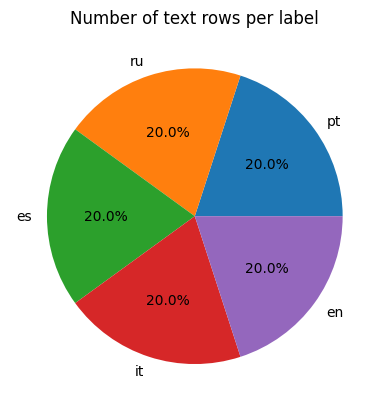

In [ ]:
# 2. Plot label distribution

label_counts = df_filtered["labels"].value_counts()
plt.figure()
plt.pie(
    label_counts.values,
    labels=label_counts.index,
    autopct="%1.1f%%"
)
plt.title("Number of text rows per label")
plt.show()


In [ ]:
# 3. Split texts per language

english_texts = df_filtered[df_filtered["labels"] == "en"]["text"].tolist()
russian_texts = df_filtered[df_filtered["labels"] == "ru"]["text"].tolist()
spanish_texts = df_filtered[df_filtered["labels"] == "es"]["text"].tolist()
italian_texts = df_filtered[df_filtered["labels"] == "it"]["text"].tolist()
portuguese_texts = df_filtered[df_filtered["labels"] == "pt"]["text"].tolist()


In [ ]:
# 4. Combine texts and labels

texts = (
    english_texts +
    russian_texts +
    spanish_texts +
    italian_texts +
    portuguese_texts
)

labels = (
    ["en"] * len(english_texts) +
    ["ru"] * len(russian_texts) +
    ["es"] * len(spanish_texts) +
    ["it"] * len(italian_texts) +
    ["pt"] * len(portuguese_texts)
)


In [ ]:
# 5. Train/val/test split (70/15/15)

from sklearn.model_selection import train_test_split

# Train / temp split
texts_train, texts_temp, labels_train, labels_temp = train_test_split(
    texts, labels,
    test_size=0.3,
    stratify=labels,
    random_state=42
)

# Validation / test split
texts_val, texts_test, labels_val, labels_test = train_test_split(
    texts_temp, labels_temp,
    test_size=0.5,  # half of temp → 15% total
    stratify=labels_temp,
    random_state=42
)


In [ ]:
# 6. Tokenizer definition

import re
import collections

class WordTokenizer:
    def __init__(self, vocabulary):
        self.vocabulary = vocabulary
        self.unk_id = vocabulary["[UNK]"]

    def standardize(self, inputs):
        return inputs.lower()

    def split(self, inputs):
        return re.findall(r"[\w]+|[.,!?;]", inputs)

    def index(self, tokens):
        return [self.vocabulary.get(t, self.unk_id) for t in tokens]

    def __call__(self, inputs):
        inputs = self.standardize(inputs)
        tokens = self.split(inputs)
        indices = self.index(tokens)
        return indices

def compute_word_vocabulary(texts, max_size):
    word_counts = collections.Counter()
    for x in texts:
        x = x.lower()
        tokens = re.findall(r"[\w]+|[.,!?;]", x)
        word_counts.update(tokens)
    vocabulary = ["[UNK]"]
    most_common = word_counts.most_common(max_size - len(vocabulary))
    for token, count in most_common:
        vocabulary.append(token)
    return dict((token, i) for i, token in enumerate(vocabulary))


In [ ]:
# 7. Build vocabulary and tokenizer

max_vocab_size = 20000
vocabulary = compute_word_vocabulary(texts_train, max_vocab_size)
word_tokenizer = WordTokenizer(vocabulary)


In [ ]:
# 8. Convert texts to multi-hot bag-of-words

import numpy as np

def texts_to_bow_multi_hot(texts, tokenizer):
    vocab_size = len(tokenizer.vocabulary)
    X = np.zeros((len(texts), vocab_size), dtype="float32")
    for i, text in enumerate(texts):
        token_ids = tokenizer(text)
        for tid in set(token_ids):  # set ensures presence only
            X[i, tid] = 1.0
    return X

X_train = texts_to_bow_multi_hot(texts_train, word_tokenizer)
X_val   = texts_to_bow_multi_hot(texts_val, word_tokenizer)
X_test  = texts_to_bow_multi_hot(texts_test, word_tokenizer)


In [ ]:
# 9. Encode labels

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(labels_train)
y_val_enc   = le.transform(labels_val)
y_test_enc  = le.transform(labels_test)


In [ ]:
# 10. Train linear classifier (set model)

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    multi_class="multinomial",  # multi-class language prediction
    max_iter=500,
    solver="lbfgs"
)

clf.fit(X_train, y_train_enc)


c:\Users\thezo\anaconda3\envs\art2\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'multinomial'


In [ ]:
# 11. Evaluate

print("Train accuracy:", clf.score(X_train, y_train_enc))
print("Validation accuracy:", clf.score(X_val, y_val_enc))
print("Test accuracy:", clf.score(X_test, y_test_enc))

# Confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test_enc, y_pred)
print("Confusion Matrix:")
print(cm)


Train accuracy: 0.9994285714285714
Validation accuracy: 0.9881904761904762
Test accuracy: 0.9900952380952381
Confusion Matrix:
[[522   0   0   1   2]
 [  1 518   4   2   0]
 [  0   0 517   1   7]
 [  1   1   1 517   5]
 [  0   0   0   0 525]]


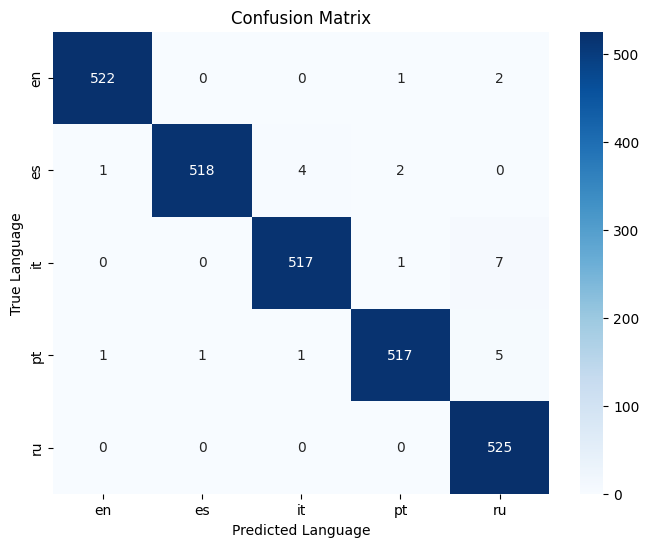

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute predictions
y_pred = clf.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test_enc, y_pred)

# Get language labels from LabelEncoder
labels = le.classes_

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,        # show numbers in cells
    fmt="d",           # integer format
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("Predicted Language")
plt.ylabel("True Language")
plt.title("Confusion Matrix")
plt.show()
